# Figure 4 - Supplementary Analyses for context-Driven Differences

In [12]:
import os
from glob import glob
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import json
from typing import Dict, List, Tuple
from scipy import stats
from scipy.spatial.distance import euclidean
from scipy.ndimage import gaussian_filter1d
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

plt.style.use('default')
plt.rcParams.update({
    'figure.figsize': [8.0, 6.0],
    'figure.dpi': 300,
    'font.size': 10,
    'svg.fonttype': 'none',
    'figure.titlesize': 9,
    'axes.titlesize': 9,
    'axes.labelsize': 8,
    'ytick.labelsize': 7,
    'xtick.labelsize': 7,
    'axes.facecolor': 'white',
    'figure.facecolor': 'white'
})

In [13]:
# Load environment variables
from dotenv import load_dotenv
load_dotenv()

# Setup paths
scratch_dir = os.getenv("SCRATCH_DIR")
OUTPUT_DIR = Path(scratch_dir) / "output_RR"
SAVE_DIR = Path(OUTPUT_DIR) / "00_final_figures" / "figure4_RR"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Colors for plotting
COLORS = {
    'affair': '#E1BE6A',
    'paranoia': '#40B0A6',
    'null': '#999999'
}

## Load Data

Load the brain state timeseries for both groups

In [14]:
from typing import Tuple, Union

def load_cluster_sequences(data_dir: Union[str, Path], cluster_id: str, model_pattern: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    Load and split cluster sequence data into affair and paranoia groups.
    
    Returns:
        tuple: (affair_data, paranoia_data) as numpy arrays
    """
    data_dir = Path(data_dir)
    folder_name = f"th_080_combined_{model_pattern}_cluster{cluster_id}"
    sequence_file = data_dir / folder_name / f"all_subjects_cluster_{cluster_id}_timeseries.pkl"
    
    with open(sequence_file, 'rb') as f:
        data = pickle.load(f)
    
    affair_sequences = []
    paranoia_sequences = []
    
    for subject, subject_data in data.items():
        timeseries = np.array(subject_data['timeseries'])
        if subject_data['group'] == 'affair':
            affair_sequences.append(timeseries)
        elif subject_data['group'] == 'paranoia':
            paranoia_sequences.append(timeseries)
    
    return np.array(affair_sequences), np.array(paranoia_sequences)

In [15]:
# Load data for multiple clusters
data_dir = Path(OUTPUT_DIR) / "07_map_cluster2stateseq"

# Define clusters to analyze (matching figure4.ipynb)
clusters_to_analyze = [
    {"cluster_id": "1", "model_pattern": "2states"},
    {"cluster_id": "2", "model_pattern": "7states"},
    {"cluster_id": "3", "model_pattern": "2states"},
    {"cluster_id": "4", "model_pattern": "6states"},
]

# Load all cluster data
cluster_data = {}
for cluster_info in clusters_to_analyze:
    cluster_id = cluster_info["cluster_id"]
    model_pattern = cluster_info["model_pattern"]
    
    try:
        affair_data, paranoia_data = load_cluster_sequences(data_dir, cluster_id, model_pattern)
        
        cluster_data[cluster_id] = {
            "affair": affair_data,
            "paranoia": paranoia_data,
            "model_pattern": model_pattern
        }
        
        print(f"Cluster {cluster_id} ({model_pattern}):")
        print(f"  Affair: {affair_data.shape[0]} subjects, {affair_data.shape[1]} TRs")
        print(f"  Paranoia: {paranoia_data.shape[0]} subjects, {paranoia_data.shape[1]} TRs")
    except FileNotFoundError as e:
        print(f"Cluster {cluster_id} ({model_pattern}): File not found - {e}")
    except Exception as e:
        print(f"Cluster {cluster_id} ({model_pattern}): Error - {e}")

Cluster 1 (2states):
  Affair: 19 subjects, 451 TRs
  Paranoia: 19 subjects, 451 TRs
Cluster 2 (7states):
  Affair: 19 subjects, 451 TRs
  Paranoia: 19 subjects, 451 TRs
Cluster 3 (2states):
  Affair: 19 subjects, 451 TRs
  Paranoia: 19 subjects, 451 TRs
Cluster 4 (6states):
  Affair: 19 subjects, 451 TRs
  Paranoia: 19 subjects, 451 TRs


## Permutation Testing

In [16]:
def compute_group_difference(group1_data: np.ndarray, group2_data: np.ndarray, 
                            metric: str = 'euclidean') -> float:
    """
    Compute difference between two groups' average timeseries.
    
    Args:
        group1_data: (n_subjects, n_timepoints) array
        group2_data: (n_subjects, n_timepoints) array
        metric: 'euclidean', 'correlation', or 'absolute_mean'
    
    Returns:
        Scalar difference measure
    """
    # Compute group averages
    group1_mean = np.mean(group1_data, axis=0)
    group2_mean = np.mean(group2_data, axis=0)
    
    if metric == 'euclidean':
        # Euclidean distance between timeseries
        return euclidean(group1_mean, group2_mean)
    
    elif metric == 'correlation':
        # 1 - correlation (so larger = more different)
        corr = np.corrcoef(group1_mean, group2_mean)[0, 1]
        return 1 - corr
    
    elif metric == 'absolute_mean':
        # Mean absolute difference across timepoints
        return np.mean(np.abs(group1_mean - group2_mean))
    
    else:
        raise ValueError(f"Unknown metric: {metric}")


def permutation_test(affair_data: np.ndarray, paranoia_data: np.ndarray, 
                    n_permutations: int = 10000, 
                    metric: str = 'euclidean',
                    random_seed: int = 42) -> Dict:
    """
    Run permutation test by randomly splitting all subjects.
    
    Args:
        affair_data: (n_affair, n_timepoints) array
        paranoia_data: (n_paranoia, n_timepoints) array
        n_permutations: Number of random splits to generate
        metric: Distance metric to use
        random_seed: Random seed for reproducibility
    
    Returns:
        Dictionary with:
            - observed_difference: True group difference
            - null_distribution: Array of differences from random splits
            - p_value: Proportion of null >= observed
            - percentile: Percentile of observed in null distribution
    """
    np.random.seed(random_seed)
    
    # Combine all subjects
    all_data = np.vstack([affair_data, paranoia_data])
    n_affair = affair_data.shape[0]
    n_paranoia = paranoia_data.shape[0]
    n_total = n_affair + n_paranoia
    
    # Compute observed difference (true groups)
    observed_diff = compute_group_difference(affair_data, paranoia_data, metric=metric)
    
    # Generate null distribution
    null_diffs = np.zeros(n_permutations)
    
    for i in range(n_permutations):
        # Randomly shuffle subjects
        shuffled_indices = np.random.permutation(n_total)
        
        # Split into two groups with same sizes as original
        random_group1 = all_data[shuffled_indices[:n_affair]]
        random_group2 = all_data[shuffled_indices[n_affair:]]
        
        # Compute difference for this random split
        null_diffs[i] = compute_group_difference(random_group1, random_group2, metric=metric)
    
    # Calculate p-value (one-tailed: observed >= null)
    p_value = np.mean(null_diffs >= observed_diff)
    
    # Calculate percentile
    percentile = stats.percentileofscore(null_diffs, observed_diff)
    
    return {
        'observed_difference': observed_diff,
        'null_distribution': null_diffs,
        'p_value': p_value,
        'percentile': percentile,
        'metric': metric,
        'n_permutations': n_permutations
    }

In [17]:
# Run permutation tests for each cluster
permutation_results = {}

for cluster_id, data in cluster_data.items():
    print(f"\nRunning permutation test for Cluster {cluster_id}...")
    
    result = permutation_test(
        affair_data=data['affair'],
        paranoia_data=data['paranoia'],
        n_permutations=10000,
        metric='euclidean'
    )
    
    permutation_results[cluster_id] = result
    
    print(f"  Observed difference: {result['observed_difference']:.4f}")
    print(f"  Null mean: {np.mean(result['null_distribution']):.4f}")
    print(f"  Null std: {np.std(result['null_distribution']):.4f}")
    print(f"  Percentile: {result['percentile']:.2f}")
    print(f"  P-value: {result['p_value']:.4f}")


Running permutation test for Cluster 1...
  Observed difference: 3.7331
  Null mean: 3.2157
  Null std: 0.2646
  Percentile: 96.42
  P-value: 0.0359

Running permutation test for Cluster 2...
  Observed difference: 2.2043
  Null mean: 2.1045
  Null std: 0.1483
  Percentile: 75.34
  P-value: 0.2488

Running permutation test for Cluster 3...
  Observed difference: 3.7331
  Null mean: 3.2157
  Null std: 0.2646
  Percentile: 96.42
  P-value: 0.0359

Running permutation test for Cluster 4...
  Observed difference: 2.5252
  Null mean: 2.2705
  Null std: 0.1410
  Percentile: 95.70
  P-value: 0.0437


## Visualization: Permutation Test Results

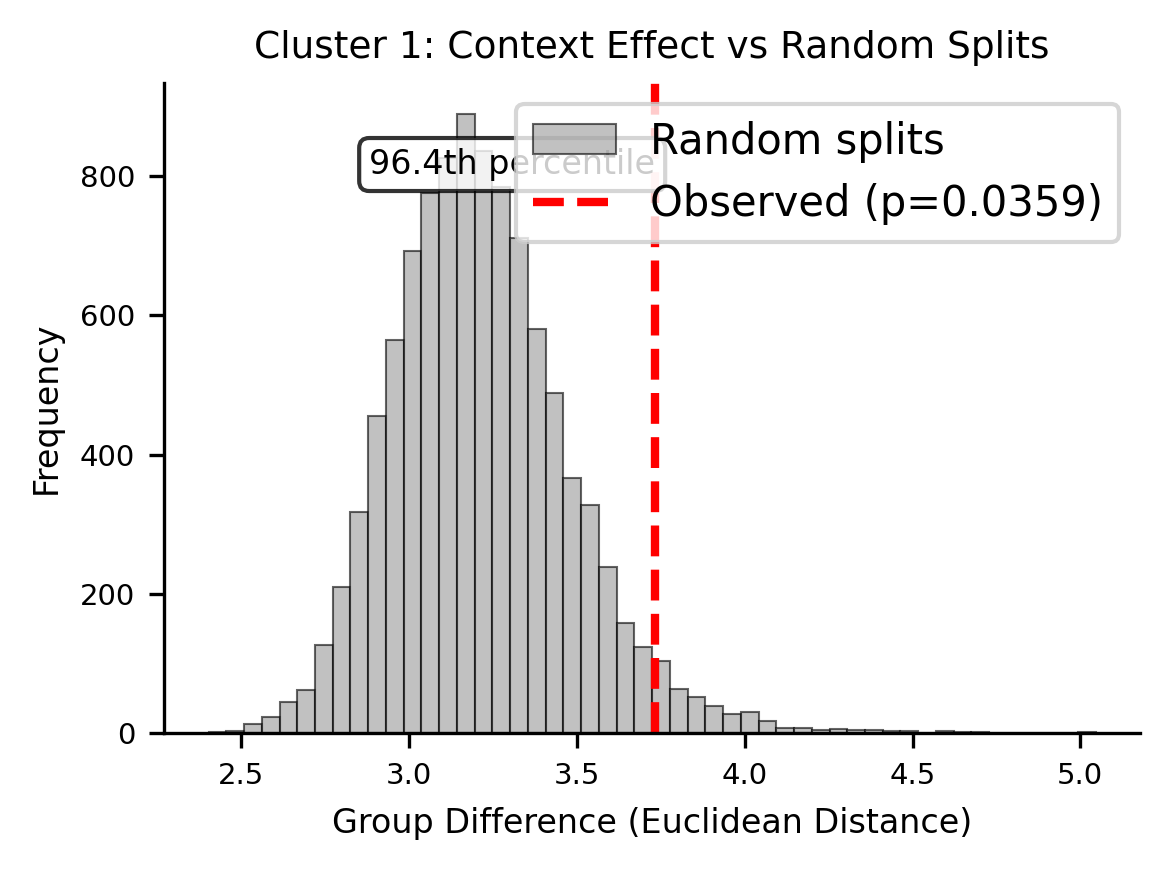

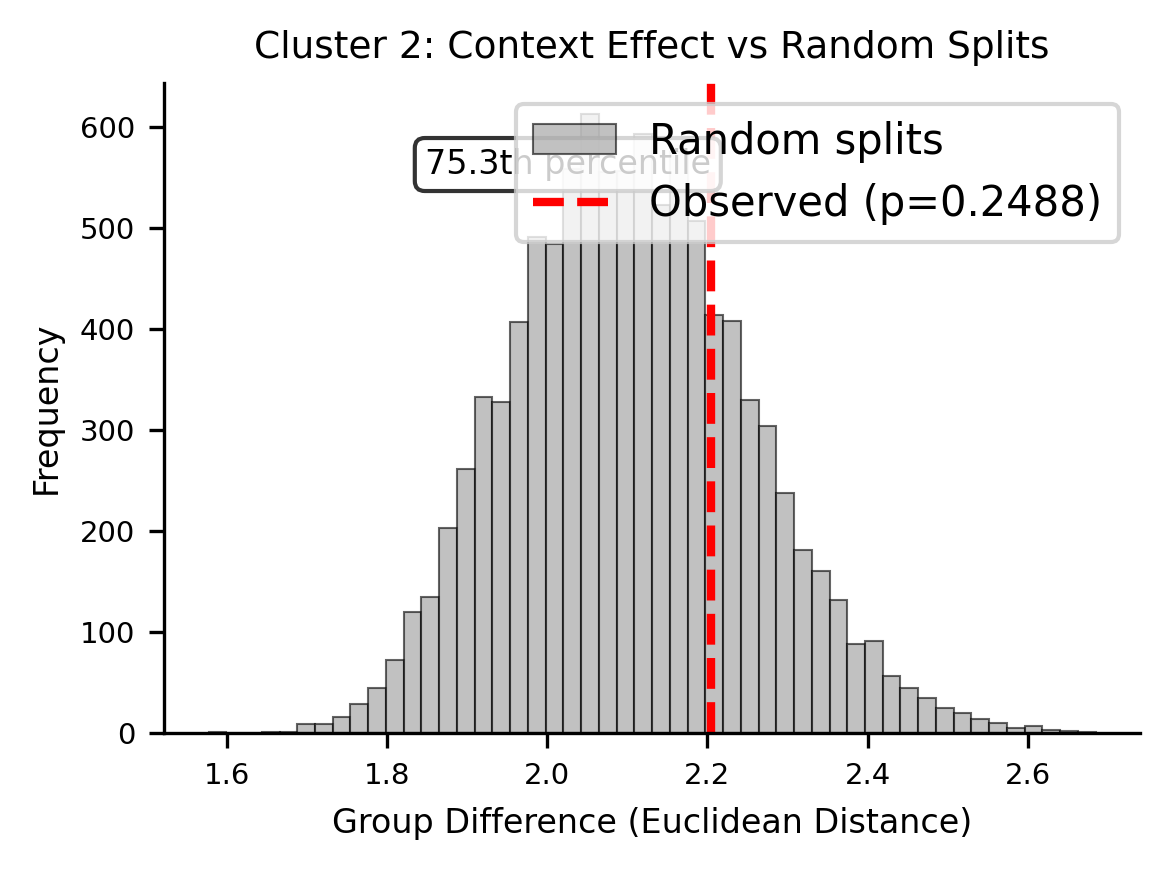

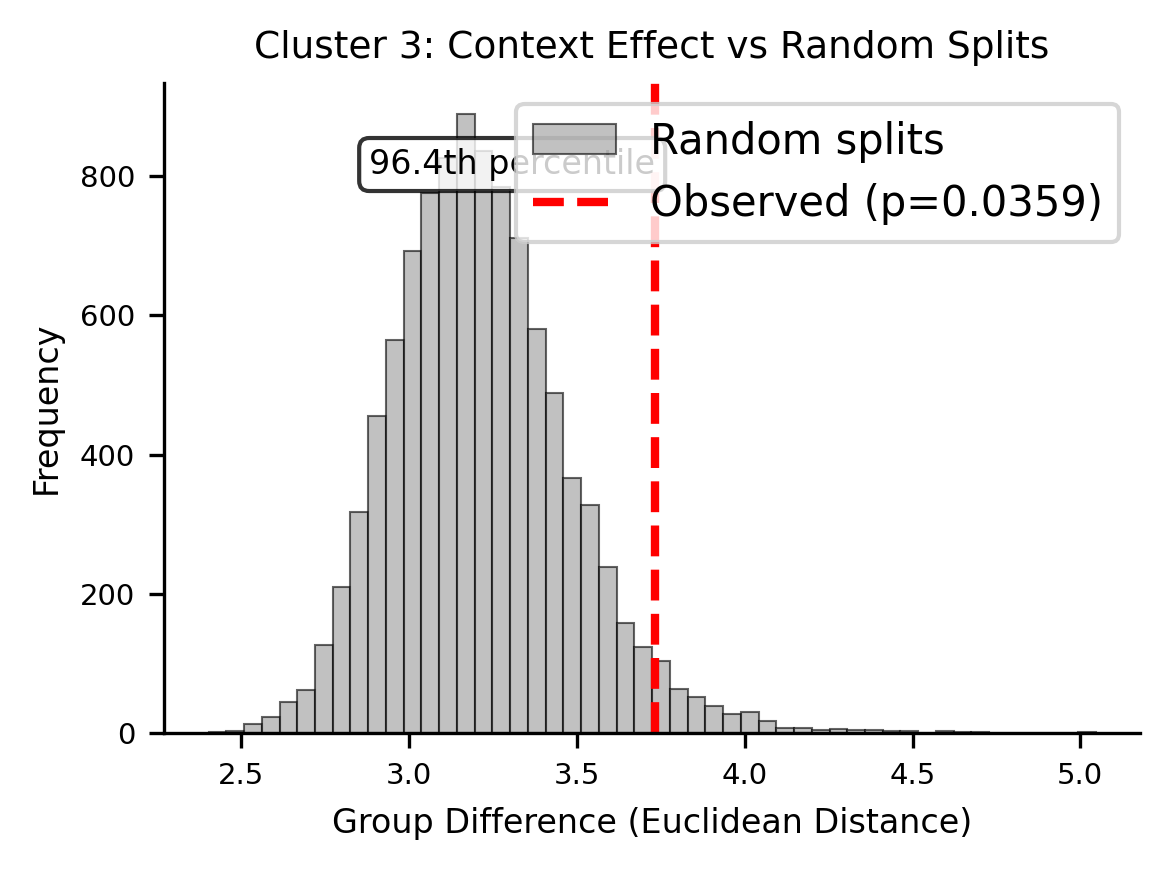

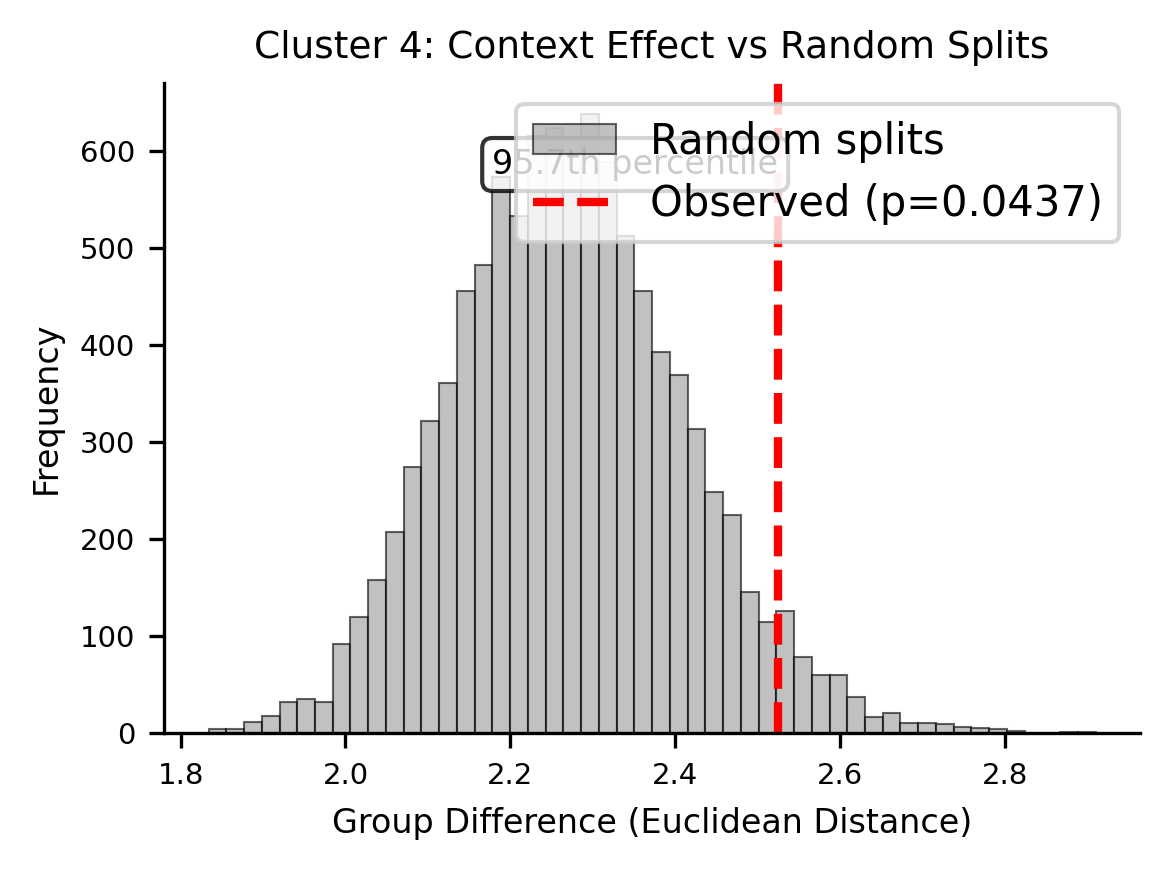

In [18]:
def plot_permutation_result(result: Dict, cluster_id: str, save_path: Path = None):
    """
    Plot permutation test results showing null distribution and observed difference.
    """
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    
    # Plot null distribution
    ax.hist(result['null_distribution'], bins=50, 
            color=COLORS['null'], alpha=0.6, 
            edgecolor='black', linewidth=0.5,
            label='Random splits')
    
    # Plot observed difference
    ax.axvline(result['observed_difference'], 
              color='red', linewidth=2, linestyle='--',
              label=f"Observed (p={result['p_value']:.4f})")
    
    # Add percentile annotation
    y_max = ax.get_ylim()[1]
    ax.text(result['observed_difference'], y_max * 0.9, 
           f"{result['percentile']:.1f}th percentile",
           ha='right', va='top', fontsize=8,
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlabel('Group Difference (Euclidean Distance)')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Cluster {cluster_id}: Context Effect vs Random Splits')
    ax.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path / f'permutation_cluster{cluster_id}.png', dpi=300, bbox_inches='tight')
        plt.savefig(save_path / f'permutation_cluster{cluster_id}.svg', bbox_inches='tight')
    
    plt.show()
    return fig

# Plot results for each cluster
for cluster_id, result in permutation_results.items():
    plot_permutation_result(result, cluster_id, SAVE_DIR)

## Temporal Dynamics Comparison

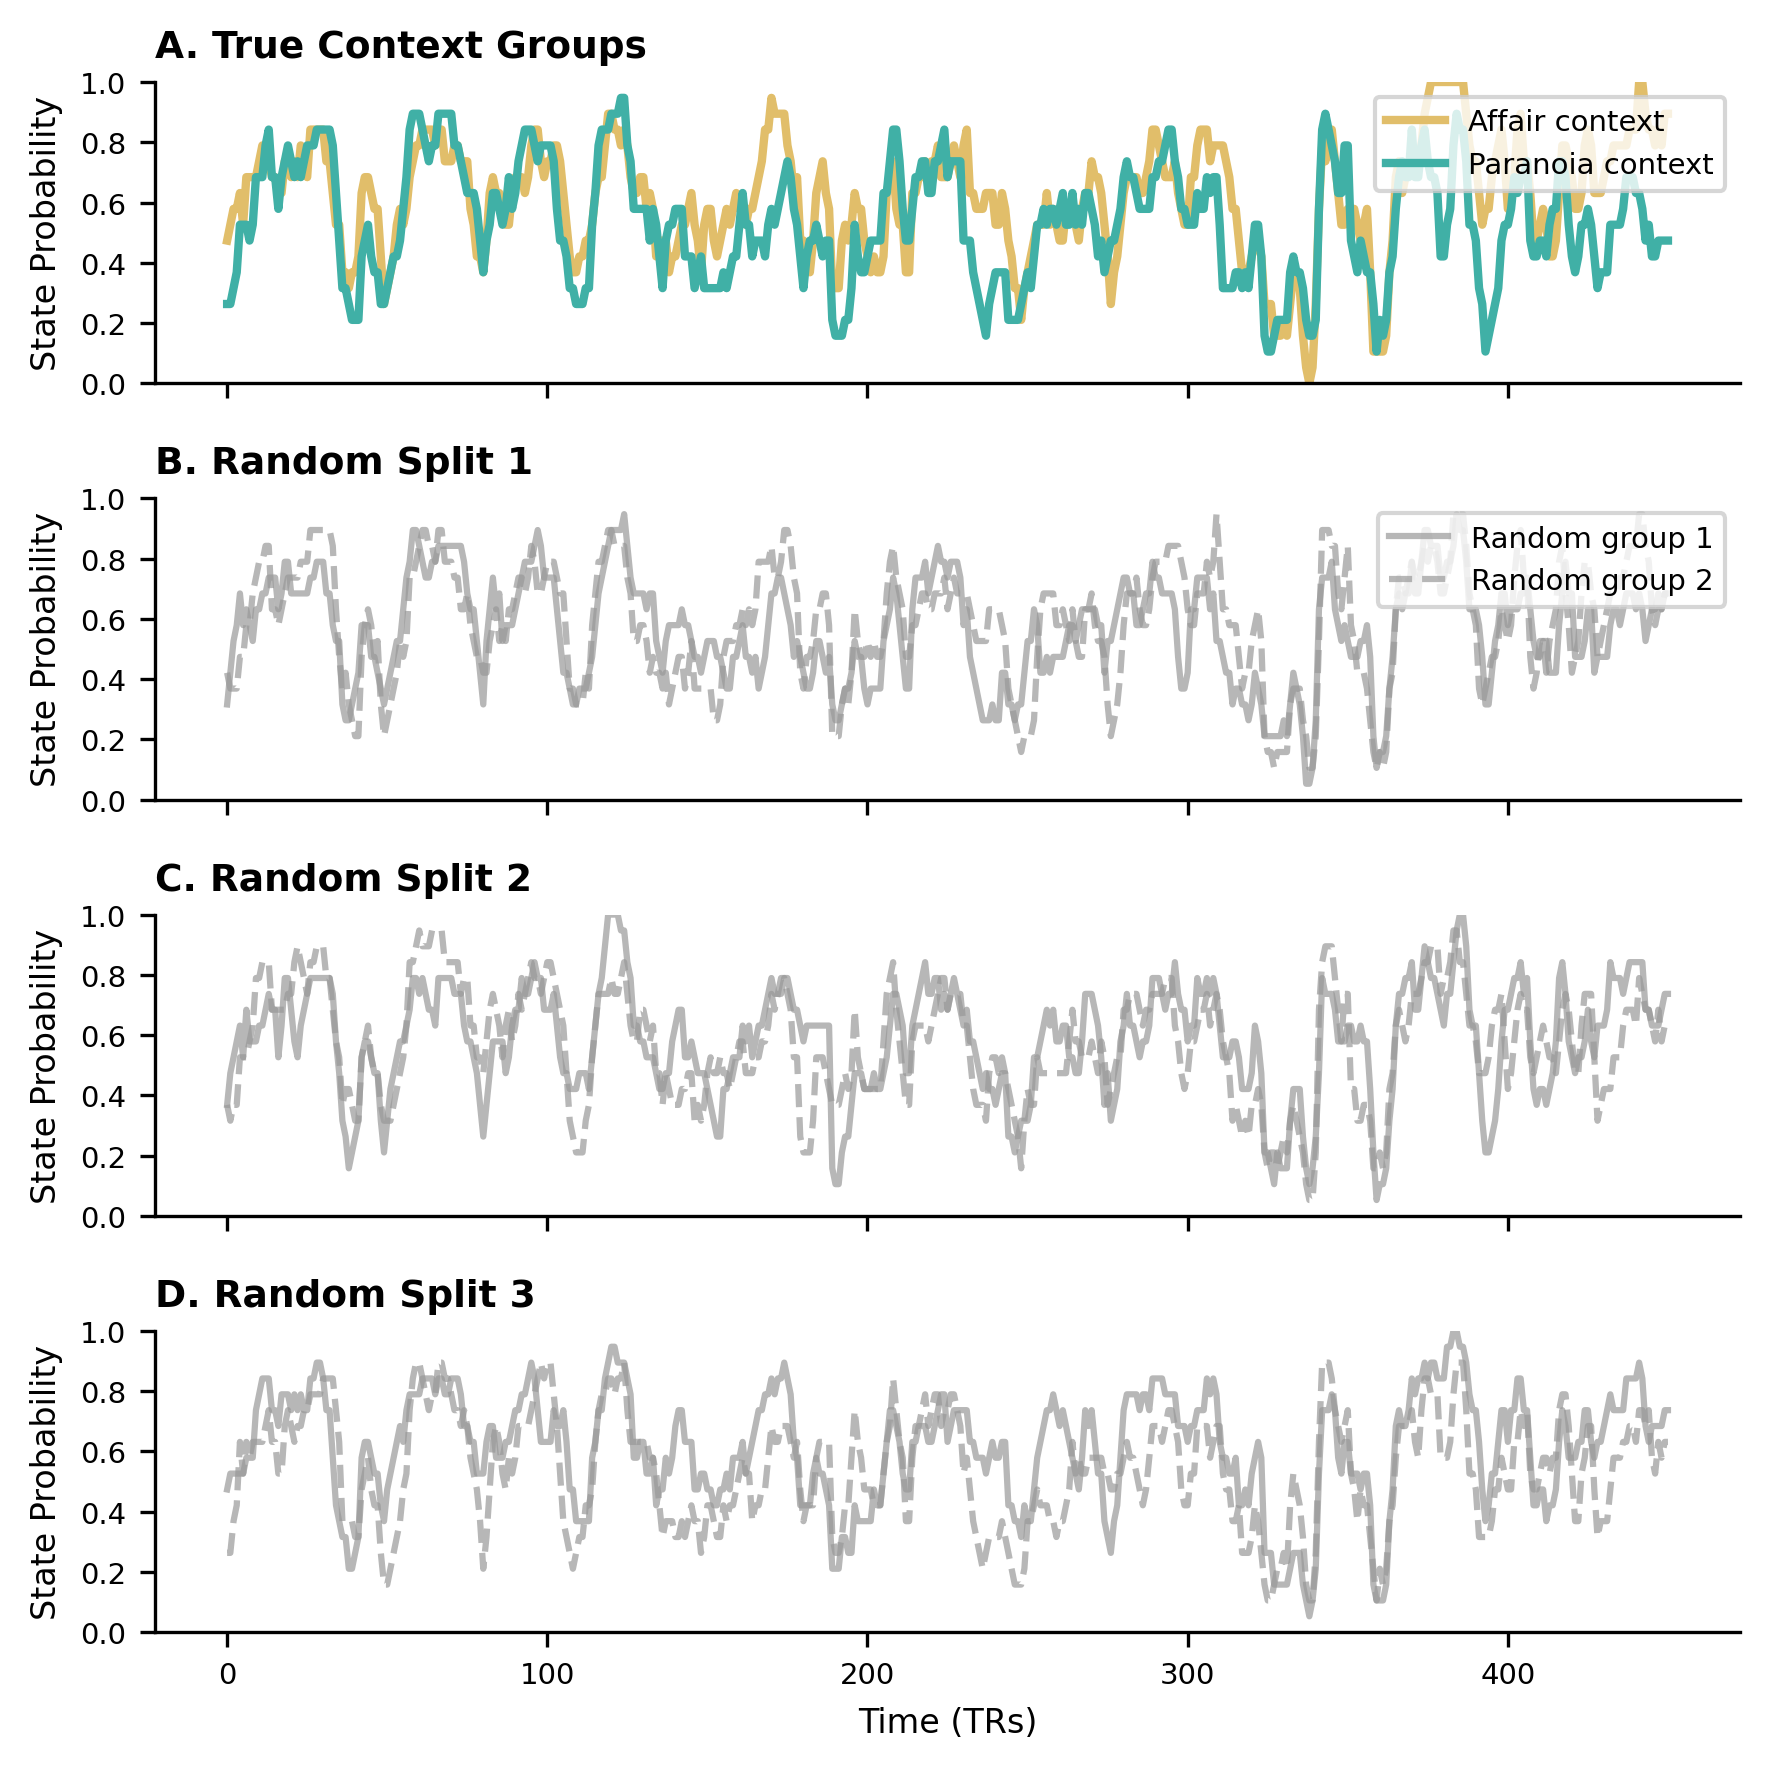

In [19]:
def plot_temporal_comparison(affair_data: np.ndarray, paranoia_data: np.ndarray,
                            cluster_id: str, n_random_examples: int = 3,
                            save_path: Path = None):
    """
    Plot true group timeseries vs examples of random splits.
    """
    n_rows = n_random_examples + 1
    fig, axes = plt.subplots(n_rows, 1, figsize=(6, n_rows * 1.5), sharex=True)
    
    # Combine all data for random splits
    all_data = np.vstack([affair_data, paranoia_data])
    n_affair = affair_data.shape[0]
    n_total = all_data.shape[0]
    
    # Plot 1: True groups
    ax = axes[0]
    ax.plot(np.mean(affair_data, axis=0), color=COLORS['affair'], 
           linewidth=2, label='Affair context')
    ax.plot(np.mean(paranoia_data, axis=0), color=COLORS['paranoia'], 
           linewidth=2, label='Paranoia context')
    ax.set_ylabel('State Probability')
    ax.set_title('A. True Context Groups', fontweight='bold', loc='left')
    ax.legend(loc='upper right', fontsize=7)
    ax.set_ylim(0, 1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Plot 2-N: Random splits
    np.random.seed(42)
    for i in range(n_random_examples):
        ax = axes[i + 1]
        
        # Random split
        shuffled = np.random.permutation(n_total)
        random_group1 = all_data[shuffled[:n_affair]]
        random_group2 = all_data[shuffled[n_affair:]]
        
        ax.plot(np.mean(random_group1, axis=0), color=COLORS['null'], 
               linewidth=1.5, alpha=0.7, label='Random group 1')
        ax.plot(np.mean(random_group2, axis=0), color=COLORS['null'], 
               linewidth=1.5, alpha=0.7, linestyle='--', label='Random group 2')
        ax.set_ylabel('State Probability')
        ax.set_title(f'{chr(66+i)}. Random Split {i+1}', fontweight='bold', loc='left')
        if i == 0:
            ax.legend(loc='upper right', fontsize=7)
        ax.set_ylim(0, 1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    axes[-1].set_xlabel('Time (TRs)')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path / f'temporal_comparison_cluster{cluster_id}.png', dpi=300, bbox_inches='tight')
        plt.savefig(save_path / f'temporal_comparison_cluster{cluster_id}.svg', bbox_inches='tight')
    
    plt.show()
    return fig

# Create comparison plots for first cluster as example
for cluster_id in ['1']:  # Can extend to all clusters
    data = cluster_data[cluster_id]
    plot_temporal_comparison(data['affair'], data['paranoia'], 
                            cluster_id, n_random_examples=3, save_path=SAVE_DIR)

## Effect Size Quantification

In [20]:
def compute_effect_sizes(permutation_result: Dict) -> Dict:
    """
    Compute effect size measures.
    """
    observed = permutation_result['observed_difference']
    null_mean = np.mean(permutation_result['null_distribution'])
    null_std = np.std(permutation_result['null_distribution'])
    
    # Cohen's d-like measure: how many SDs is observed above null mean
    cohens_d = (observed - null_mean) / null_std
    
    # Fold-change: how many times larger is observed vs null mean
    fold_change = observed / null_mean if null_mean > 0 else np.nan
    
    return {
        'cohens_d': cohens_d,
        'fold_change': fold_change,
        'null_mean': null_mean,
        'null_std': null_std
    }

# Compute effect sizes
effect_sizes = {}
for cluster_id, result in permutation_results.items():
    effect_sizes[cluster_id] = compute_effect_sizes(result)
    
    print(f"\nCluster {cluster_id} Effect Sizes:")
    print(f"  Cohen's d: {effect_sizes[cluster_id]['cohens_d']:.2f}")
    print(f"  Fold change: {effect_sizes[cluster_id]['fold_change']:.2f}x")

# Create summary table
summary_data = []
for cluster_id in permutation_results.keys():
    summary_data.append({
        'Cluster': cluster_id,
        'Model': cluster_data[cluster_id]['model_pattern'],
        'Observed Difference': permutation_results[cluster_id]['observed_difference'],
        'Null Mean ± SD': f"{effect_sizes[cluster_id]['null_mean']:.3f} ± {effect_sizes[cluster_id]['null_std']:.3f}",
        "Cohen's d": effect_sizes[cluster_id]['cohens_d'],
        'Fold Change': effect_sizes[cluster_id]['fold_change'],
        'Percentile': permutation_results[cluster_id]['percentile'],
        'P-value': permutation_results[cluster_id]['p_value']
    })

summary_df = pd.DataFrame(summary_data)
print("\nSummary Table:")
print(summary_df.to_string(index=False))

# Save summary
summary_df.to_csv(SAVE_DIR / 'permutation_summary.csv', index=False)
print(f"\nSaved summary to {SAVE_DIR / 'permutation_summary.csv'}")


Cluster 1 Effect Sizes:
  Cohen's d: 1.96
  Fold change: 1.16x

Cluster 2 Effect Sizes:
  Cohen's d: 0.67
  Fold change: 1.05x

Cluster 3 Effect Sizes:
  Cohen's d: 1.96
  Fold change: 1.16x

Cluster 4 Effect Sizes:
  Cohen's d: 1.81
  Fold change: 1.11x

Summary Table:
Cluster   Model  Observed Difference Null Mean ± SD  Cohen's d  Fold Change  Percentile  P-value
      1 2states             3.733134  3.216 ± 0.265   1.955359     1.160891      96.420   0.0359
      2 7states             2.204252  2.105 ± 0.148   0.672315     1.047391      75.345   0.2488
      3 2states             3.733134  3.216 ± 0.265   1.955359     1.160891      96.420   0.0359
      4 6states             2.525219  2.271 ± 0.141   1.805663     1.112166      95.700   0.0437

Saved summary to /orcd/scratch/bcs/001/yibei/prettymouth/output_RR/00_final_figures/figure4_RR/permutation_summary.csv


## Combined Figure Panel

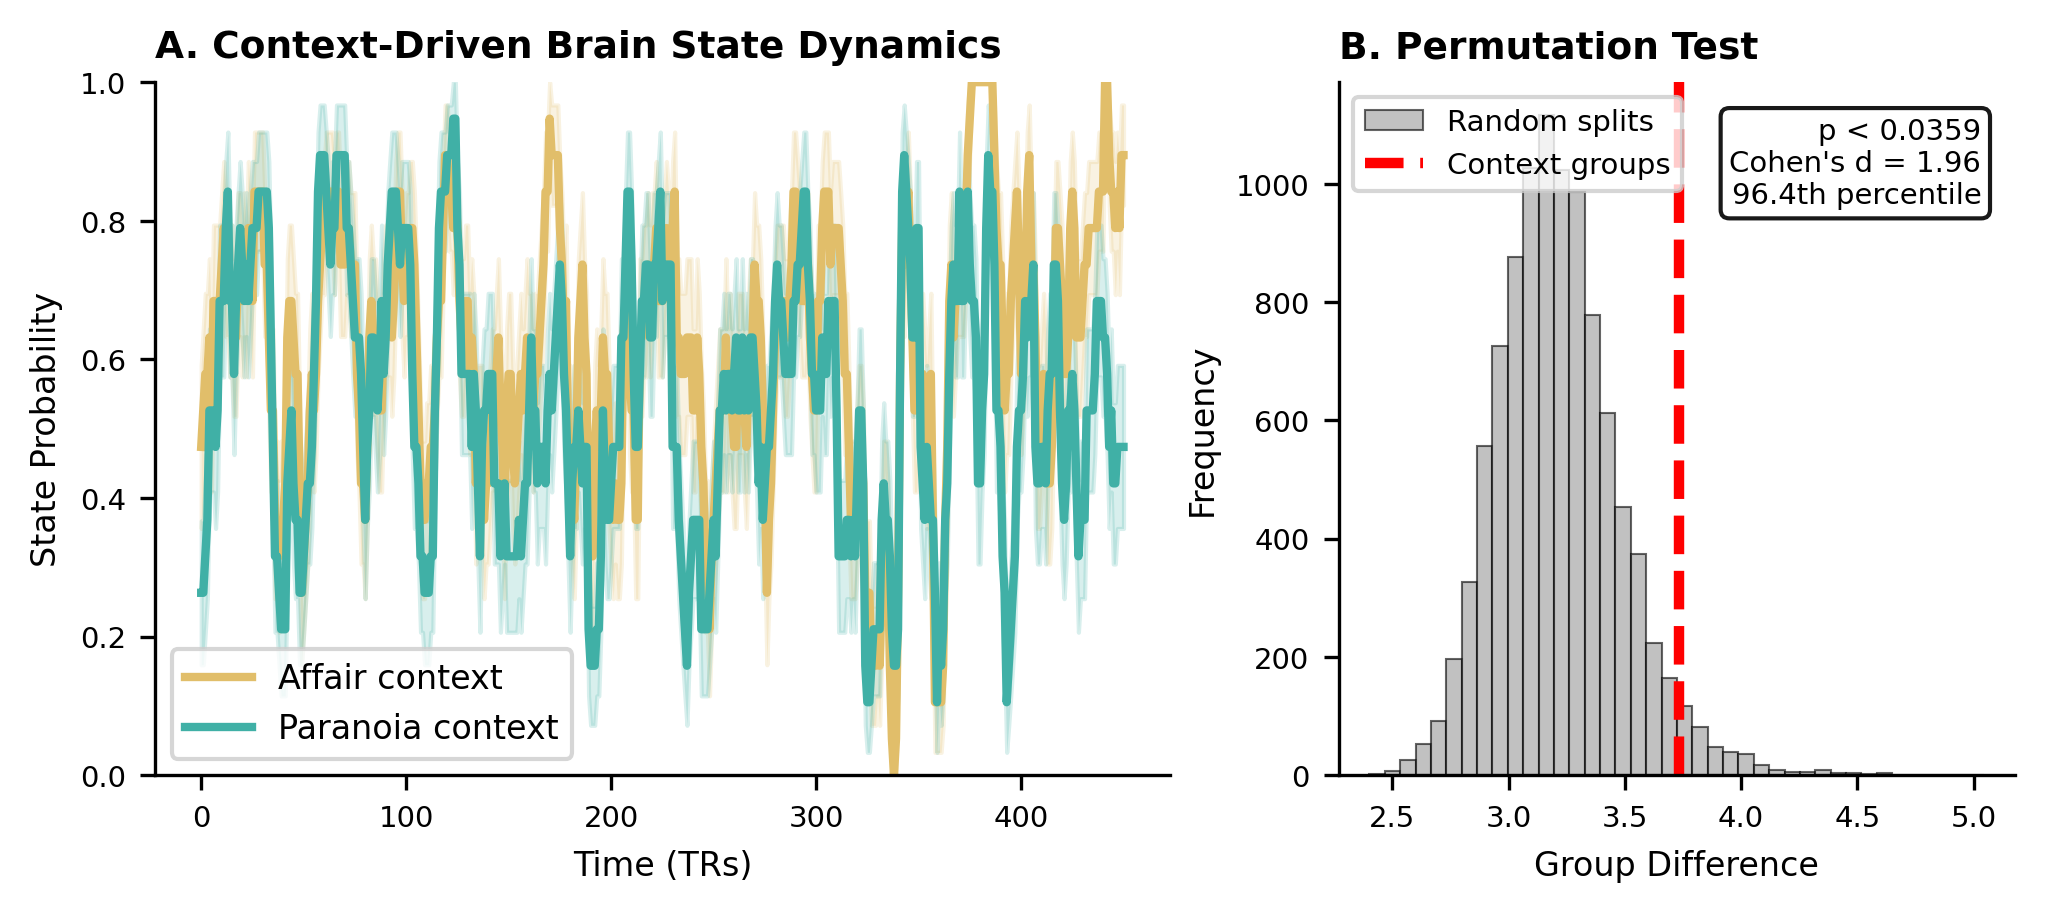

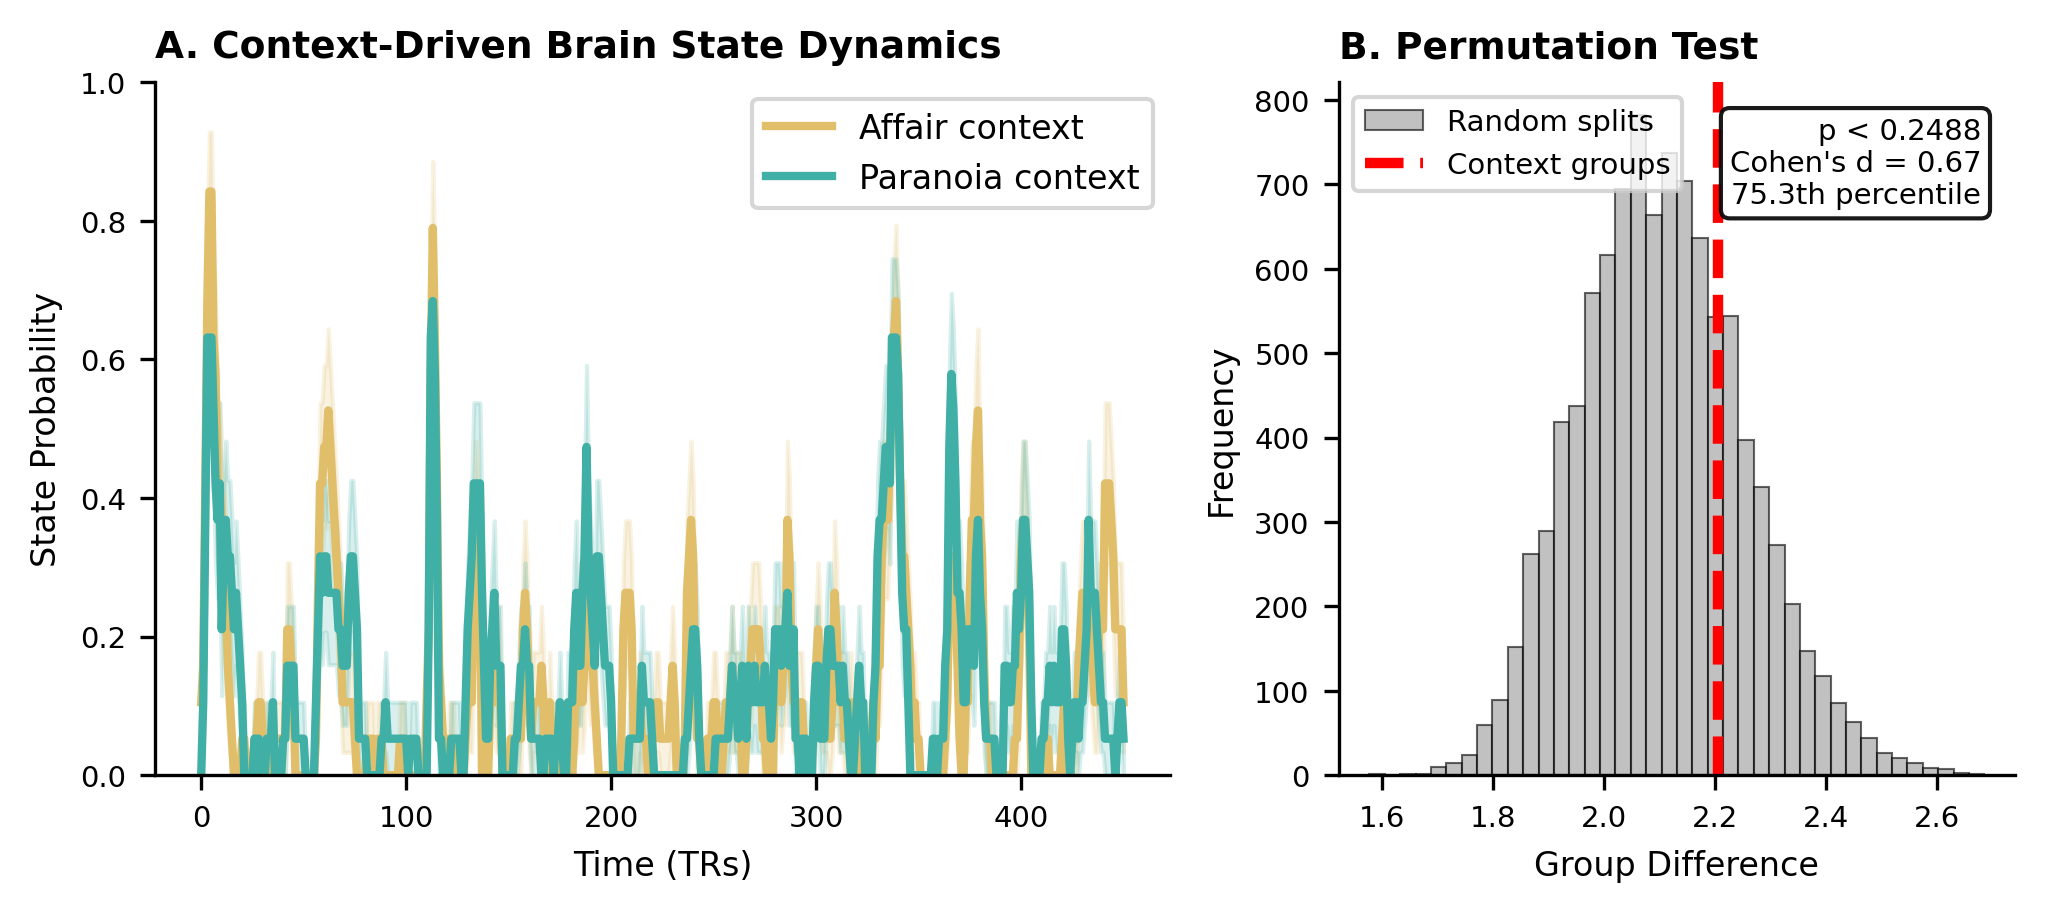

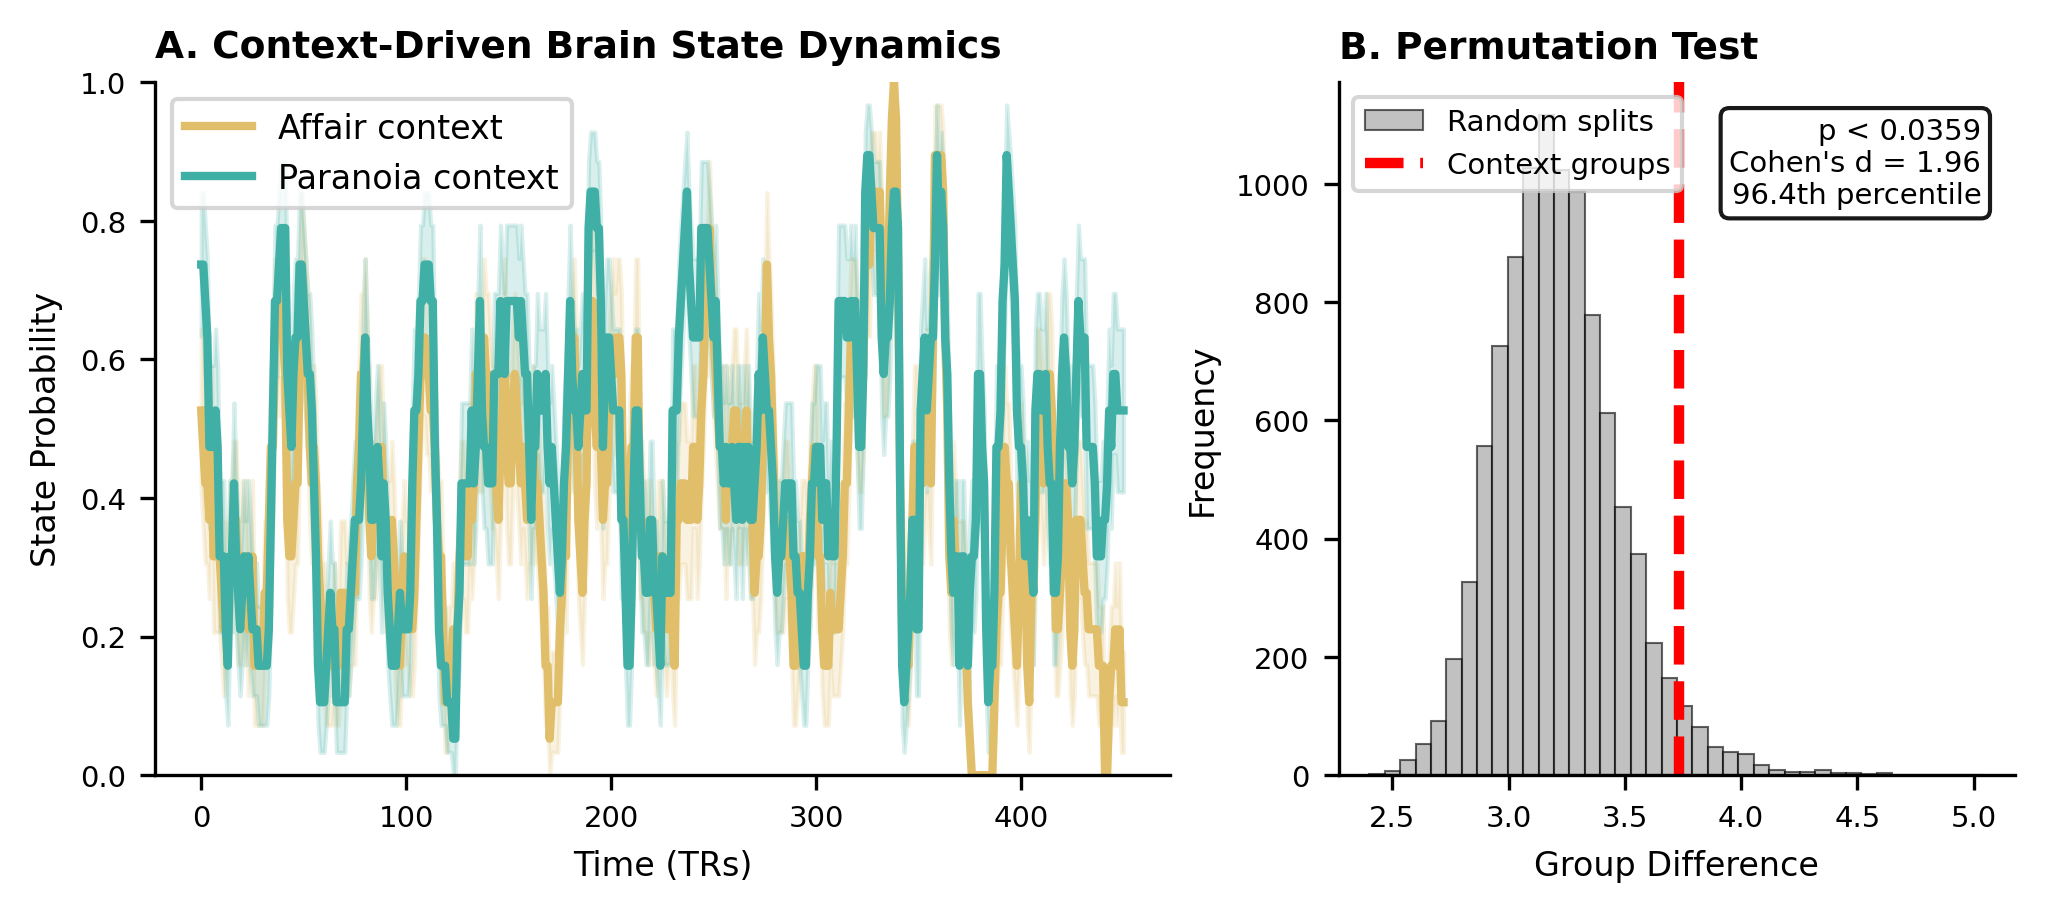

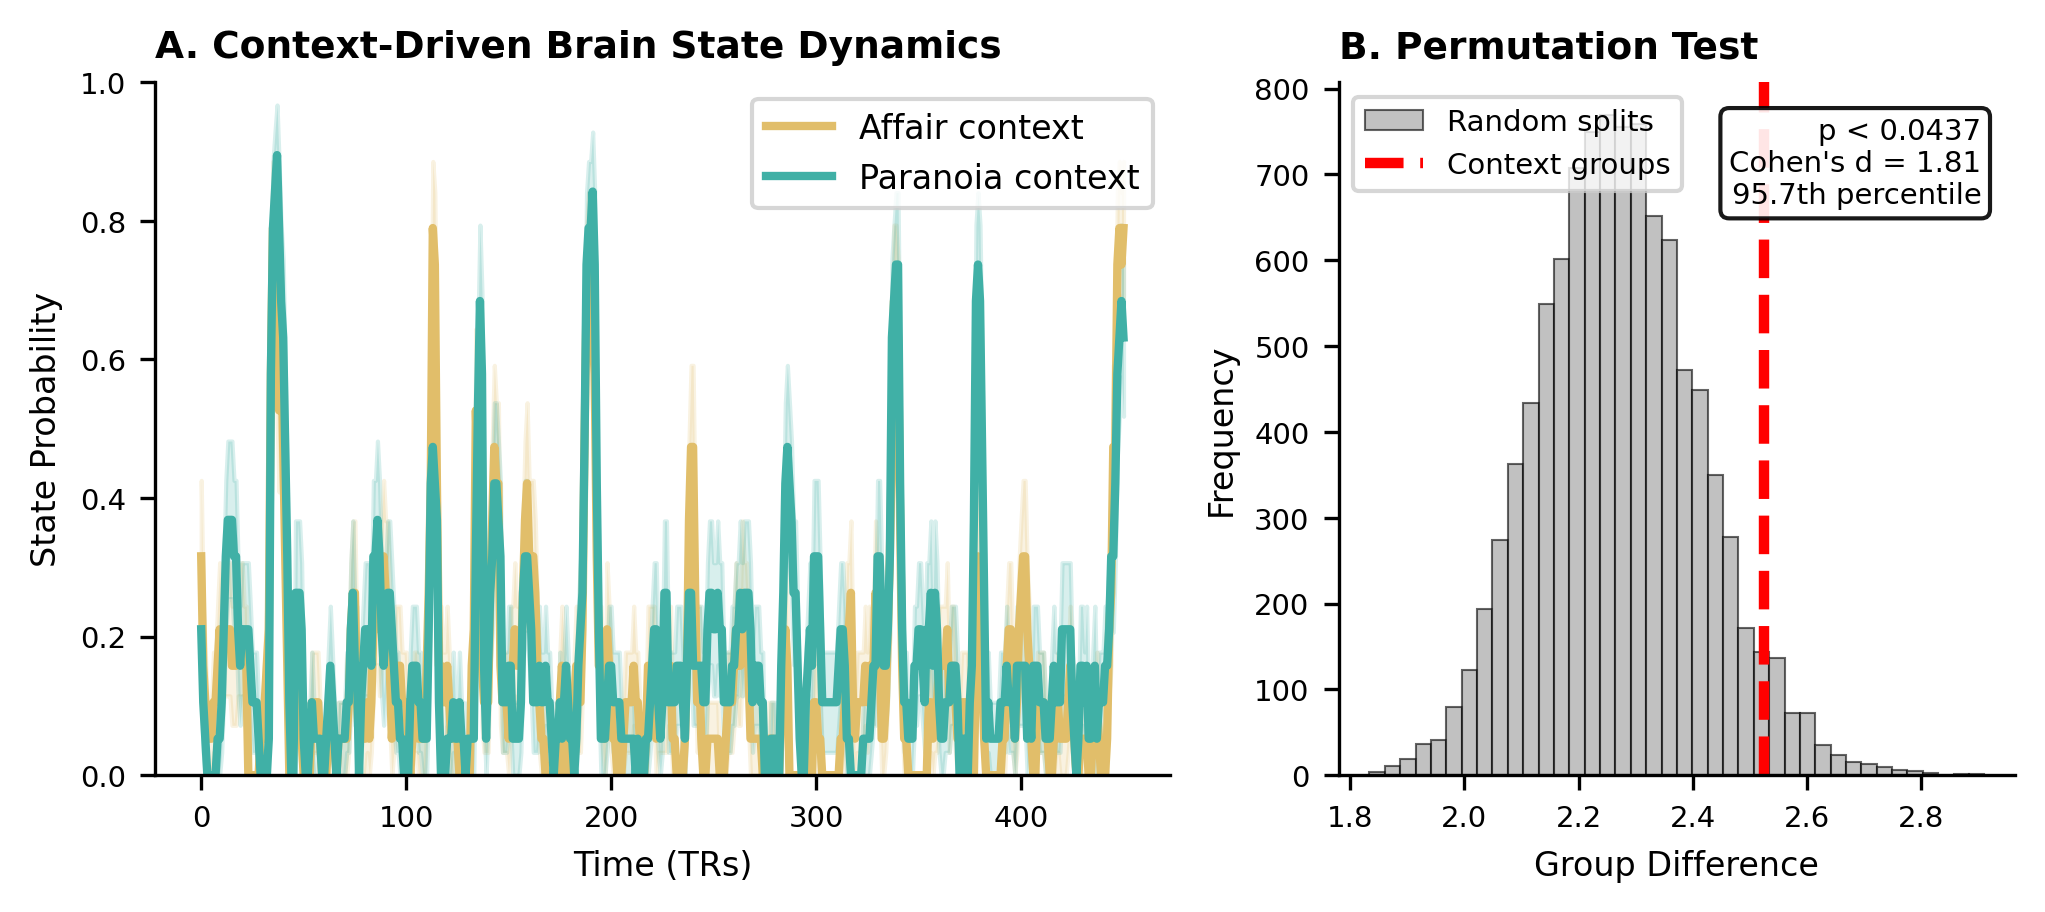

In [21]:
def create_combined_figure(cluster_id: str, affair_data: np.ndarray, 
                          paranoia_data: np.ndarray, perm_result: Dict,
                          save_path: Path = None):
    """
    Create a 2-panel figure showing:
    A) Temporal dynamics of true groups
    B) Permutation test results
    """
    fig = plt.figure(figsize=(8, 3))
    gs = fig.add_gridspec(1, 2, width_ratios=[1.5, 1], hspace=0.3)
    
    # Panel A: Temporal dynamics
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(np.mean(affair_data, axis=0), color=COLORS['affair'], 
            linewidth=2, label='Affair context')
    ax1.plot(np.mean(paranoia_data, axis=0), color=COLORS['paranoia'], 
            linewidth=2, label='Paranoia context')
    
    # Add shaded error bands (SEM)
    affair_sem = stats.sem(affair_data, axis=0)
    paranoia_sem = stats.sem(paranoia_data, axis=0)
    
    ax1.fill_between(range(affair_data.shape[1]),
                     np.mean(affair_data, axis=0) - affair_sem,
                     np.mean(affair_data, axis=0) + affair_sem,
                     color=COLORS['affair'], alpha=0.2)
    ax1.fill_between(range(paranoia_data.shape[1]),
                     np.mean(paranoia_data, axis=0) - paranoia_sem,
                     np.mean(paranoia_data, axis=0) + paranoia_sem,
                     color=COLORS['paranoia'], alpha=0.2)
    
    ax1.set_xlabel('Time (TRs)')
    ax1.set_ylabel('State Probability')
    ax1.set_title('A. Context-Driven Brain State Dynamics', fontweight='bold', loc='left')
    ax1.legend(fontsize=8)
    ax1.set_ylim(0, 1)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    # Panel B: Permutation test
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.hist(perm_result['null_distribution'], bins=40, 
            color=COLORS['null'], alpha=0.6, 
            edgecolor='black', linewidth=0.5,
            label='Random splits')
    
    ax2.axvline(perm_result['observed_difference'], 
               color='red', linewidth=2.5, linestyle='--',
               label='Context groups')
    
    # Add statistics text box
    effect_size = compute_effect_sizes(perm_result)
    stats_text = f"p < {perm_result['p_value']:.4f}\n"
    stats_text += f"Cohen's d = {effect_size['cohens_d']:.2f}\n"
    stats_text += f"{perm_result['percentile']:.1f}th percentile"
    
    ax2.text(0.95, 0.95, stats_text, 
            transform=ax2.transAxes,
            ha='right', va='top', fontsize=7,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    ax2.set_xlabel('Group Difference')
    ax2.set_ylabel('Frequency')
    ax2.set_title('B. Permutation Test', fontweight='bold', loc='left')
    ax2.legend(fontsize=7, loc='upper left')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path / f'combined_figure_cluster{cluster_id}.png', dpi=300, bbox_inches='tight')
        plt.savefig(save_path / f'combined_figure_cluster{cluster_id}.svg', bbox_inches='tight')
    
    plt.show()
    return fig

# Create combined figures for each cluster
for cluster_id in cluster_data.keys():
    create_combined_figure(
        cluster_id=cluster_id,
        affair_data=cluster_data[cluster_id]['affair'],
        paranoia_data=cluster_data[cluster_id]['paranoia'],
        perm_result=permutation_results[cluster_id],
        save_path=SAVE_DIR
    )